In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PATH_OF_DATA= '/content/drive/MyDrive/dataset'
!ls {PATH_OF_DATA}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data  test  train


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode
import torch
import os 
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
data_dir = '/content/drive/MyDrive/dataset'
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                     for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

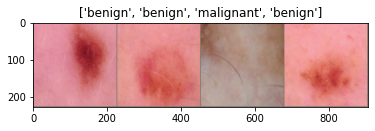

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    # Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
    def visualize_model(model, num_images=6):
        was_training = model.training
        model.eval()
        images_so_far = 0
        fig = plt.figure()

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(dataloaders['test']):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                for j in range(inputs.size()[0]):
                    images_so_far += 1
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                    imshow(inputs.cpu().data[j])

                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        return
            model.train(mode=was_training)

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6726 Acc: 0.6974
test Loss: 0.3663 Acc: 0.8091

Epoch 1/24
----------
train Loss: 0.5664 Acc: 0.7474
test Loss: 0.5970 Acc: 0.6864

Epoch 2/24
----------
train Loss: 0.4905 Acc: 0.7854
test Loss: 0.3450 Acc: 0.8485

Epoch 3/24
----------
train Loss: 0.4109 Acc: 0.8104
test Loss: 0.3471 Acc: 0.8318

Epoch 4/24
----------
train Loss: 0.4013 Acc: 0.8305
test Loss: 0.7060 Acc: 0.7015

Epoch 5/24
----------
train Loss: 0.3507 Acc: 0.8400
test Loss: 0.3529 Acc: 0.8242

Epoch 6/24
----------
train Loss: 0.3508 Acc: 0.8373
test Loss: 0.2816 Acc: 0.8788

Epoch 7/24
----------
train Loss: 0.2909 Acc: 0.8669
test Loss: 0.2855 Acc: 0.8712

Epoch 8/24
----------
train Loss: 0.2728 Acc: 0.8768
test Loss: 0.2893 Acc: 0.8773

Epoch 9/24
----------
train Loss: 0.2606 Acc: 0.8836
test Loss: 0.3039 Acc: 0.8561

Epoch 10/24
----------
train Loss: 0.2643 Acc: 0.8790
test Loss: 0.2975 Acc: 0.8667

Epoch 11/24
----------
train Loss: 0.2682 Acc: 0.8821
test Loss: 0.2690 Acc

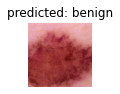

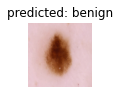

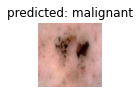

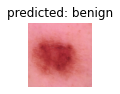

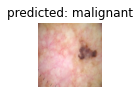

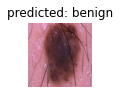

In [ ]:
visualize_model(model_ft)

In [ ]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6739 Acc: 0.6962
test Loss: 0.5178 Acc: 0.7621

Epoch 1/24
----------
train Loss: 0.6101 Acc: 0.7402
test Loss: 0.3856 Acc: 0.8273

Epoch 2/24
----------
train Loss: 0.5976 Acc: 0.7342
test Loss: 0.4439 Acc: 0.8182

Epoch 3/24
----------
train Loss: 0.5905 Acc: 0.7505
test Loss: 0.4151 Acc: 0.8167

Epoch 4/24
----------
train Loss: 0.6454 Acc: 0.7338
test Loss: 0.6497 Acc: 0.7561

Epoch 5/24
----------
train Loss: 0.6431 Acc: 0.7391
test Loss: 0.5454 Acc: 0.7485

Epoch 6/24
----------
train Loss: 0.6046 Acc: 0.7512
test Loss: 0.5641 Acc: 0.7606

Epoch 7/24
----------
train Loss: 0.4576 Acc: 0.7899
test Loss: 0.4300 Acc: 0.8061

Epoch 8/24
----------
train Loss: 0.4601 Acc: 0.7929
test Loss: 0.3793 Acc: 0.8227

Epoch 9/24
----------
train Loss: 0.4418 Acc: 0.7922
test Loss: 0.3776 Acc: 0.8197

Epoch 10/24
----------
train Loss: 0.4635 Acc: 0.7838
test Loss: 0.3735 Acc: 0.8303

Epoch 11/24
----------
train Loss: 0.4499 Acc: 0.7922
test Loss: 0.3839 Acc

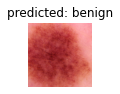

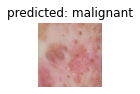

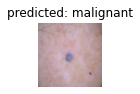

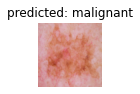

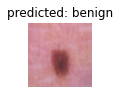

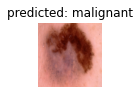

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
from PIL import Image
import time
from torch.autograd import Variable
import json
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
from PIL import Image
from collections import OrderedDict
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
image_path = '/content/drive/MyDrive/dataset/test/benign/1719.jpg'
img = Image.open(image_path)

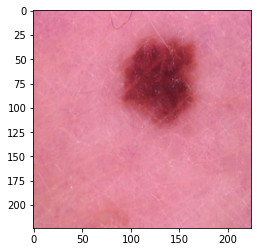

In [ ]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    # tensor.numpy().transpose(1, 2, 0)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    return image
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
with Image.open(image_path) as image:
    plt.imshow(image)
model_ft.class_to_idx = image_datasets['train'].class_to_idx

In [ ]:
def predict2(image_path, model, topk=2):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    img = Image.open(image_path)
    img = process_image(img)
    
    # Convert 2D image to 1D vector
    img = np.expand_dims(img, 0)
    
    
    img = torch.from_numpy(img)
    
    model.eval()
    inputs = Variable(img).to(device)
    logits = model.forward(inputs)
    
    ps = F.softmax(logits,dim=1)
    topk = ps.cpu().topk(topk)
    
    return (e.data.numpy().squeeze().tolist() for e in topk)

In [ ]:
img_path = '/content/drive/MyDrive/dataset/test/benign/1719.jpg'
probs, classes = predict2(img_path, model_ft.to(device))
print(probs)
print(classes)

[0.9999970197677612, 2.953072907985188e-06]
[0, 1]


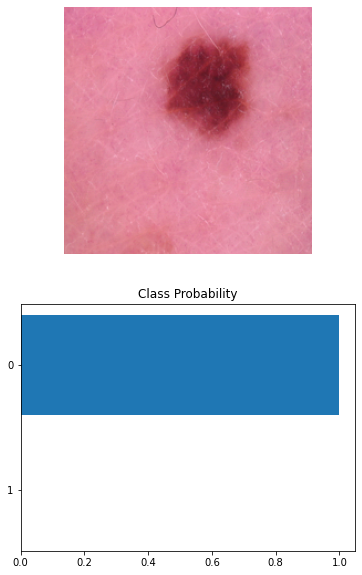

In [ ]:
def view_classify(img_path, prob, classes):
    ''' Function for viewing an image and it's predicted classes.
    '''
    image = Image.open(img_path)
    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    
    
    ax1.imshow(image)
    ax1.axis('off')
    
    y_pos = np.arange(len(prob))
    ax2.barh(y_pos, prob, align='center')
    ax2.set_yticks(y_pos)
    
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_title('Class Probability')
view_classify(img_path, probs, classes)